# [COM6513] Assignment 2: Text Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward neural network for text classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**2 marks**)


- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**2 marks**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**2 marks**)
    - **Output layer** with a **softmax** activation. (**2 marks**)


- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**2 marks**)
    - Perform a **Forward pass** to compute intermediate outputs (**5 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**12 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**4 marks**)



- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500}, the dropout rate {e.g. 0.2, 0.5} and the learning rate. Please use tables or graphs to show training and validation performance for each hyperparameter combination  (**5 marks**). 



- After training a model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy. Does your model overfit, underfit or is about right? (**2 marks**).



- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**7 marks**).



- Extend you Feedforward network by adding more hidden layers (e.g. one more or two). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**8 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices (**5 marks**). 



- Provide efficient solutions by using Numpy arrays when possible. Executing the whole notebook with your code should not take more than 10 minutes on any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs and loading the pretrained vectors. You can find tips in [Intro to Python for NLP](https://sheffieldnlp.github.io/com6513/assets/labs/a0_python_intro.pdf) (**2 marks**). 



### Data 

The data you will use for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You should submit a Jupyter Notebook file (assignment2.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).


You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are **not allowed to use any third-party library** such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras, Pytorch etc.. You should mention if you've used Windows to write and test your code because we mostly use Unix based machines for marking (e.g. Ubuntu, MacOS). 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 60. It is worth 60\% of your final grade in the module.

The deadline for this assignment is **23:59 on Fri, 23 Apr 2021** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
from datetime import datetime 
import gc

# fixing random seed for reproducibility
myseed = 406
random.seed(myseed)
np.random.seed(myseed)
start_time = datetime.now()
EPOCH = 100

## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
train_df = pd.read_csv('./data_topic/train.csv', names = ['label','articles'])
dev_df = pd.read_csv('./data_topic/dev.csv', names = ['label','articles'])
test_df = pd.read_csv('./data_topic/test.csv', names = ['label','articles'])

In [3]:
# to put the raw texts into Python lists and their corresponding labels into NumPy arrays
train_articles = list(train_df['articles'].values)
dev_articles = list(dev_df['articles'].values)
test_articles = list(test_df['articles'].values)

train_labels = train_df['label'].values
dev_labels = dev_df['label'].values
test_labels = test_df['label'].values

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [4]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [5]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                   stop_words=[], vocab=set()):
    
    tokenRE = re.compile(token_pattern)
    # first extract all unigrams by tokenising
    x_uni = [w for w in tokenRE.findall(str(x_raw).lower(),) if w not in stop_words]
    # this is to store the ngrams to be returned
    x = []
    
    if ngram_range[0]==1:
        x = x_uni

    # generate n-grams from the available unigrams x_uni
    ngrams = []
    for n in range(ngram_range[0], ngram_range[1]+1):

    # ignore unigrams
        if n==1: continue

        # pass a list of lists as an argument for zip
        arg_list = [x_uni]+[x_uni[i:] for i in range(1, n)]

        # extract tuples of n-grams using zip
        # for bigram this should look: list(zip(x_uni, x_uni[1:]))
        # align each item x[i] in x_uni with the next one x[i+1]. 
        # Note that x_uni and x_uni[1:] have different lenghts
        # but zip ignores redundant elements at the end of the second list
        # Alternatively, this could be done with for loops
        x_ngram = list(zip(*arg_list))
        ngrams.append(x_ngram)

    for n in ngrams:
        for t in n:
            x.append(t)

    if len(vocab)>0:
        x = [w for w in x if w in vocab]
        
    return x

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [6]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, 
              stop_words=[]):
    
    tokenRE = re.compile(token_pattern)
    
    df = Counter()
    ngram_counts = Counter()
    vocab = set()
    
    # interate through each raw text
    for x in X_raw:    
        x_ngram = extract_ngrams(x, ngram_range=ngram_range, token_pattern=token_pattern, 
                                 stop_words=stop_words)
        
        #update doc and ngram frequencies 
        df.update(list(set(x_ngram)))
        ngram_counts.update(x_ngram)

    # obtain a vocabulary as a set. 
    # Keep elements with doc frequency > minimum doc freq (min_df)
    # Note that df contains all te
    vocab = set([w for w in df if df[w]>=min_df])
    
    # keep the top N most freqent 
    if keep_topN>0:
        vocab = set([w[0] for w in ngram_counts.most_common(keep_topN) 
                     if w[0] in vocab])
    
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [7]:
vocab, df, ngram_counts = get_vocab(train_articles, ngram_range=(1,1), 
                                    stop_words=stop_words,keep_topN=2000,min_df=10)

Then, you need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [8]:
word2id = {}
id2word = {}

for word in vocab:
    if word not in word2id:
        new_id = len(word2id)
        word2id[word] = new_id
        id2word[new_id] = word

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [9]:
# use this func to extract the uni gram in each articals and store them as a list
def getUniGramList(articles_list):
    uni_word_list = [] # to store the word list for each articial
    for i in range(len(articles_list)):
        word = extract_ngrams(articles_list[i],ngram_range=(1,1), 
                           token_pattern=r'\b[A-Za-z][A-Za-z]+\b',
                           stop_words = stop_words, vocab = vocab)
        uni_word_list.append(word)
    return uni_word_list

In [10]:
words_list_tra = getUniGramList(train_articles)
words_list_dev = getUniGramList(dev_articles)
words_list_test = getUniGramList(test_articles)

Then convert them into lists of indices in the vocabulary:

In [11]:
# use the word2id fuc to get the indices lists
def getWordId(articals):
    index_outter = []
    for artical_index in range(len(articals)):
        index_inner = []
        for word in articals[artical_index]:
            index_inner.append(word2id[word])
        index_outter.append(index_inner)
    return index_outter

In [12]:
X_tr = getWordId(words_list_tra)
X_dev = getWordId(words_list_dev)
X_te = getWordId(words_list_test)

Put the labels `Y` for train, dev and test sets into arrays: 

In [13]:
Y_tr = train_labels - 1 # here train_labels: 0 1 2 
Y_dev = dev_labels -1
Y_te = test_labels -1

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [14]:
# my
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.5):
    
    # W is used to store weight matrixes
    W = []
    
    # imput W + hidden W + output W
    layer_dim_list = [vocab_size,embedding_dim] + hidden_dim + [num_classes] # the nodes number list of layers
    
    
    for i in range(len(layer_dim_list)-1):
        # initialise the weight matrix
        temp_w = np.random.uniform(-0.1,0.1,(layer_dim_list[i],layer_dim_list[i+1]))
        temp_w = np.float32(temp_w)
        W.append(temp_w)
    return W

In [15]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[2], num_classes=2)
for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

Shape W0 (3, 4)
Shape W1 (4, 2)
Shape W2 (2, 2)


Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [16]:
def softmax(z):
    z = np.array(z)
    z = np.exp(z)  
    sig = z / np.sum(z)
    return sig # sum(sig) = 1

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:


In [17]:
def categorical_loss(y, y_preds):
    l = -np.log(y_preds[y])
    return l

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [18]:
def relu(z):
    a = np.maximum(z,0)
    return a
    
def relu_derivative(z):
    dz = np.array(z,copy = True)
    dz[dz<=0] = 0
    dz[dz>0]=1
    return dz

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [19]:
# set some nodes as 0
def dropout_mask(size, dropout_rate):
    rng = np.random.default_rng()
    dropout_vec = np.float64(rng.binomial(1,1-dropout_rate,size))
    return dropout_vec 

In [20]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[0. 1. 1. 1. 1. 1. 0. 0. 1. 0.]
[0. 1. 1. 0. 1. 0. 1. 0. 1. 1.]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [21]:
def forward_pass(x, W, dropout_rate=0.2):
    out_vals = {}
    h_vecs = []
    a_vecs = []
    dropout_vecs = []
    
    # convert x to vector 
    X_vec = np.zeros((1,len(W[0])))[0]
    for i in x:
        X_vec[i] = 1/len(x)
    
    temp_h = []
    temp_a = [X_vec]
    
    # The pipeline
        # 1、vector * w  
        # 2、relu
        # 3、dropout
        # ```repeat```
        # 4、softmax
    for i in range(len(W)):
        temp_h = np.dot(temp_a,W[i])
        dropout_temp = dropout_mask(W[i].shape[1],dropout_rate) # W[i].shape[1] is the node numbers of current layer
        temp_a = relu(temp_h* dropout_temp) # activation func
    
        h_vecs.append(temp_h)
        a_vecs.append(temp_a)
        dropout_vecs.append(dropout_temp)
    
    # softmax is used to convert input to prob
    y = softmax(temp_h) 
   
    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['dropout_vecs'] = dropout_vecs[:-1]
    out_vals['y'] = y
    
    return out_vals

The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [22]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    
    # softmax derivate
    y_preds = out_vals['y'][0]
    y_preds[y] = y_preds[y]-1
    g = y_preds.reshape((1,out_vals['y'].shape[1]))
    
    # update w
    W[1] = W[1] - lr * np.dot(out_vals['a'][0].T, g)
    g = np.dot(g, W[1].T)
    
    # if the freeze_emb = False ,then update the embedding layer
    if freeze_emb == False:
        X_vec = np.zeros((1,len(W[0])))[0]
        for i in x:
            X_vec[i] = 1
        
        X_vec = X_vec.reshape((1,X_vec.shape[0]))
        g = g * relu_derivative(out_vals['h'][0])
        W[0] = W[0] - lr * np.dot(X_vec.T,g)
    
    return W

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [23]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, print_progress=True):
    
    training_loss_history = []
    validation_loss_history = []
    count = 0
    X_tr_len = len(X_tr)
    X_dev_len = len(X_dev)
    
    # prepare for shuffle
    index_list = list(range(len(Y_tr)))
    
    # repeat update untill meet the threshold
    while True:
        # shuffle the index
        np.random.shuffle(index_list) 
        
        # update the W
        for i in index_list: 
            out_vals = forward_pass(X_tr[i], W, dropout_rate=dropout) 
            W = backward_pass(X_tr[i], Y_tr[i], W, out_vals, lr=lr, freeze_emb=freeze_emb)
           
        # calculate and store the loss of each eopch on train set
        temp_train_loss = 0
        for i in range(X_tr_len): 
            out_vals = forward_pass(X_tr[i], W, dropout_rate=dropout)
            temp_train_loss += categorical_loss(Y_tr[i], out_vals['y'][0])
        temp_train_loss /= X_tr_len # the average loss
        training_loss_history.append(temp_train_loss)
        
        # calculate and store the loss of each eopch on dev set
        temp_val_loss = 0
        for i in range(X_dev_len): 
            out_vals = forward_pass(X_dev[i], W, dropout_rate=dropout)
            temp_val_loss += categorical_loss(Y_dev[i], out_vals['y'][0])
        temp_val_loss /= X_dev_len # the average loss
        validation_loss_history.append(temp_val_loss)
        
        # print the loss every 10 epoches
        if print_progress and (count%10 == 0): 
            print("Epoch:",count, "training_loss:", temp_train_loss,"validation_loss: ", temp_val_loss)
        
        # the threshold：the loss between two epoch must smaller than tolarance 
        # and the epoch must bigger than 50 and smaller than epoches
        count += 1
        if ((0 < (validation_loss_history[count-2] - validation_loss_history[count-1]) <= tolerance)&count>50) | (count >= epochs):
            break
     
    return W, training_loss_history, validation_loss_history

Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [24]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,
                    hidden_dim=[], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)
    
W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.001, 
                            dropout=0.2,
                            freeze_emb=False,
                            tolerance=0.0001,
                            epochs=EPOCH)

Shape W0 (1103, 300)
Shape W1 (300, 3)
Epoch: 0 training_loss: 1.094727538609735 validation_loss:  1.094201635970594
Epoch: 10 training_loss: 1.0333445571161906 validation_loss:  1.0522682279934334
Epoch: 20 training_loss: 0.8309434172206179 validation_loss:  0.8991804895450027
Epoch: 30 training_loss: 0.5841562430637391 validation_loss:  0.6686515394833727
Epoch: 40 training_loss: 0.42756328895231577 validation_loss:  0.5095581023229117
Epoch: 50 training_loss: 0.34219757178374965 validation_loss:  0.423661048230724
Epoch: 60 training_loss: 0.28593503102120593 validation_loss:  0.37537450619499313
Epoch: 70 training_loss: 0.24956327601593964 validation_loss:  0.3571994636165245
Epoch: 80 training_loss: 0.2184356197821079 validation_loss:  0.3439634722507073
Epoch: 90 training_loss: 0.194749016826336 validation_loss:  0.333924238123621


Plot the learning process:

In [25]:
def plot_train_val_loss(loss_tr,dev_loss):
    epoch = np.arange(1,len(loss_tr)+1)
    train_loss_list = []
    dev_loss_list = []
    for index in epoch:
        train_loss_list.append(loss_tr[index-1])
        dev_loss_list.append(dev_loss[index-1])
        
    plt.plot(epoch, train_loss_list,label='train loss')
    plt.plot(epoch, dev_loss_list,label = 'validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()  

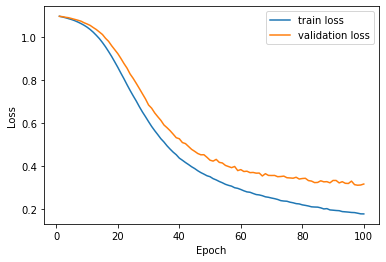

In [26]:
plot_train_val_loss(loss_tr,dev_loss)

Compute accuracy, precision, recall and F1-Score:

In [27]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) 
            for x,y in zip(X_te,Y_te)]

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))
end_time = datetime.now()
cost_time=(end_time-start_time).seconds
print("Total time: ",cost_time/60," minutes.")

Accuracy: 0.8466666666666667
Precision: 0.8487828432018829
Recall: 0.8466666666666667
F1-Score: 0.8463527852937996
Total time:  3.0833333333333335  minutes.


### Discuss how did you choose model hyperparameters ? 

In [28]:
# define a func to recive hyperparameters
def grid_search(embedding_dim,dropout_rate):
    
    # print current hyperparameter
    print("The embedding_size:",embedding_dim,"; The dropout_rate:",dropout_rate)
    
    # intilise W
    W = network_weights(vocab_size=len(vocab),embedding_dim=embedding_dim,hidden_dim=[], num_classes=3)    
    
    # training and update the W
    W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                                W,
                                X_dev=X_dev, 
                                Y_dev=Y_dev,
                                lr=0.001, 
                                dropout = dropout_rate,
                                freeze_emb = False,
                                tolerance = 0.0001,
                                epochs = EPOCH)

    preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) 
                for x,y in zip(X_te,Y_te)]
    
    plot_train_val_loss(loss_tr,dev_loss)
    
    print()
    print('Accuracy:', accuracy_score(Y_te,preds_te))
    print('Precision:', precision_score(Y_te,preds_te,average='macro'))
    print('Recall:', recall_score(Y_te,preds_te,average='macro'))
    print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))
    print("-----------------------")

The embedding_size: 50 ; The dropout_rate: 0.2
Epoch: 0 training_loss: 1.0983158421654144 validation_loss:  1.0982120888195233
Epoch: 10 training_loss: 1.089883719846309 validation_loss:  1.0927296388724437
Epoch: 20 training_loss: 1.0442093851462246 validation_loss:  1.0598126879683845
Epoch: 30 training_loss: 0.8638889479888064 validation_loss:  0.9187843811118159
Epoch: 40 training_loss: 0.637674461233425 validation_loss:  0.7169668980059664
Epoch: 50 training_loss: 0.4700438582351917 validation_loss:  0.5520745999313742
Epoch: 60 training_loss: 0.3753081002275816 validation_loss:  0.45896232096630174
Epoch: 70 training_loss: 0.31565465195789416 validation_loss:  0.38693555317001493
Epoch: 80 training_loss: 0.27933926782593504 validation_loss:  0.34275293353229086
Epoch: 90 training_loss: 0.24595858019806646 validation_loss:  0.3512764328648499


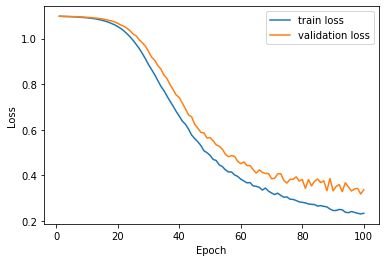


Accuracy: 0.8444444444444444
Precision: 0.8460523293449436
Recall: 0.8444444444444444
F1-Score: 0.8442794913809119
-----------------------
The embedding_size: 50 ; The dropout_rate: 0.5
Epoch: 0 training_loss: 1.0980679632623966 validation_loss:  1.0982204234021364
Epoch: 10 training_loss: 1.0918793427216662 validation_loss:  1.093796171249154
Epoch: 20 training_loss: 1.0675947511950201 validation_loss:  1.076552283527095
Epoch: 30 training_loss: 0.980442191950572 validation_loss:  1.0121261756886228
Epoch: 40 training_loss: 0.8197170052182018 validation_loss:  0.8729781134753529
Epoch: 50 training_loss: 0.65495292685044 validation_loss:  0.7575239701503259
Epoch: 60 training_loss: 0.5289157216759265 validation_loss:  0.6284488658361834
Epoch: 70 training_loss: 0.44771790068982703 validation_loss:  0.5421905027437769
Epoch: 80 training_loss: 0.39893382252726756 validation_loss:  0.41883649940982415
Epoch: 90 training_loss: 0.3598163489783055 validation_loss:  0.44180455041057143


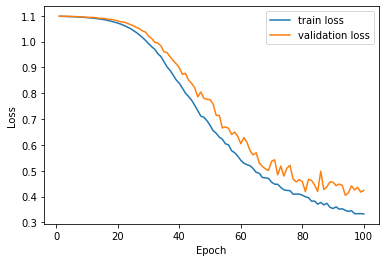


Accuracy: 0.8455555555555555
Precision: 0.8468799695466184
Recall: 0.8455555555555555
F1-Score: 0.845305304948838
-----------------------
The embedding_size: 300 ; The dropout_rate: 0.2
Epoch: 0 training_loss: 1.0954011580203455 validation_loss:  1.0968063663622318
Epoch: 10 training_loss: 1.0411748178581046 validation_loss:  1.0584542878769028
Epoch: 20 training_loss: 0.8517986719861579 validation_loss:  0.9156824650507389
Epoch: 30 training_loss: 0.595131740581498 validation_loss:  0.6815221237484849
Epoch: 40 training_loss: 0.4322203830630759 validation_loss:  0.5162634763993565
Epoch: 50 training_loss: 0.3440842560793702 validation_loss:  0.4322068138851162
Epoch: 60 training_loss: 0.2892345788299199 validation_loss:  0.37724436951805945
Epoch: 70 training_loss: 0.24939672016005854 validation_loss:  0.3551020511666356
Epoch: 80 training_loss: 0.22271941507728102 validation_loss:  0.3267114011144186
Epoch: 90 training_loss: 0.19743806009266412 validation_loss:  0.33593723055212765


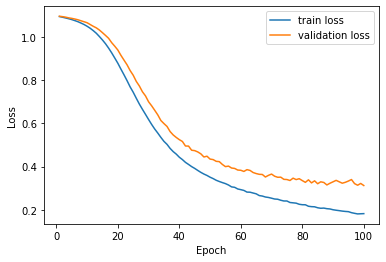


Accuracy: 0.8477777777777777
Precision: 0.8497350638214597
Recall: 0.8477777777777776
F1-Score: 0.8475611797292966
-----------------------
The embedding_size: 300 ; The dropout_rate: 0.5
Epoch: 0 training_loss: 1.0970895094088962 validation_loss:  1.0975266219432396
Epoch: 10 training_loss: 1.0672455966294054 validation_loss:  1.078102286290827
Epoch: 20 training_loss: 0.9746102264592984 validation_loss:  1.011016024349797
Epoch: 30 training_loss: 0.7890898458566004 validation_loss:  0.8638674461421763
Epoch: 40 training_loss: 0.6071456385777027 validation_loss:  0.68034056752896
Epoch: 50 training_loss: 0.46983578684674115 validation_loss:  0.5451813570438364
Epoch: 60 training_loss: 0.38756803023726394 validation_loss:  0.4606989393914854
Epoch: 70 training_loss: 0.33626325479811825 validation_loss:  0.41636669824774275
Epoch: 80 training_loss: 0.2926991211143816 validation_loss:  0.37792202914214645
Epoch: 90 training_loss: 0.26194347940007334 validation_loss:  0.35375499519378784


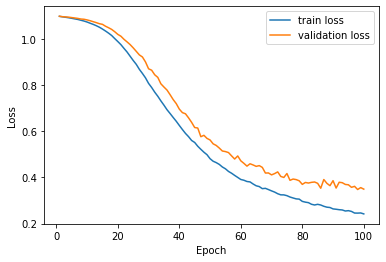


Accuracy: 0.8444444444444444
Precision: 0.8460361907606532
Recall: 0.8444444444444444
F1-Score: 0.8440835474902663
-----------------------
The embedding_size: 500 ; The dropout_rate: 0.2
Epoch: 0 training_loss: 1.0934491674867488 validation_loss:  1.0946647134194651
Epoch: 10 training_loss: 1.0072348574165335 validation_loss:  1.0352576189831686
Epoch: 20 training_loss: 0.7731466230052162 validation_loss:  0.8472885911298853
Epoch: 30 training_loss: 0.5358934875171685 validation_loss:  0.6200726783367342
Epoch: 40 training_loss: 0.40229755661883654 validation_loss:  0.4941948118264963
Epoch: 50 training_loss: 0.3257187690120242 validation_loss:  0.41443892580489994
Epoch: 60 training_loss: 0.27430069985553557 validation_loss:  0.38005725666061063
Epoch: 70 training_loss: 0.23917110675718434 validation_loss:  0.35101219598295313
Epoch: 80 training_loss: 0.21126323422786214 validation_loss:  0.3421518084412019
Epoch: 90 training_loss: 0.1890588304934071 validation_loss:  0.3198759567406

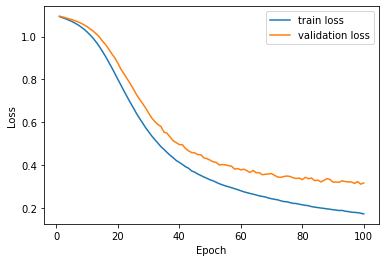


Accuracy: 0.8466666666666667
Precision: 0.848586322361674
Recall: 0.8466666666666667
F1-Score: 0.8464370470285854
-----------------------
The embedding_size: 500 ; The dropout_rate: 0.5
Epoch: 0 training_loss: 1.0959649210847622 validation_loss:  1.097003649665907
Epoch: 10 training_loss: 1.0479990575577476 validation_loss:  1.0652267511344087
Epoch: 20 training_loss: 0.9147567629408053 validation_loss:  0.9646443062155695
Epoch: 30 training_loss: 0.7072971913592094 validation_loss:  0.7974003024715922
Epoch: 40 training_loss: 0.5379250533954796 validation_loss:  0.6125273256244732
Epoch: 50 training_loss: 0.4259989396787058 validation_loss:  0.4944352307279268
Epoch: 60 training_loss: 0.35604099036009224 validation_loss:  0.43730134165374657
Epoch: 70 training_loss: 0.30733971180480724 validation_loss:  0.4073350914682223
Epoch: 80 training_loss: 0.2735632501216638 validation_loss:  0.37265367991222687
Epoch: 90 training_loss: 0.24521609718516094 validation_loss:  0.35508065601698663

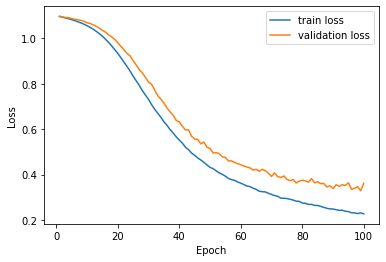


Accuracy: 0.8411111111111111
Precision: 0.8429445649806692
Recall: 0.8411111111111111
F1-Score: 0.8408373036417256
-----------------------


In [29]:
# lists of the hyperparameters for grid search
embedding_size = [50, 300, 500]
dropout_rate = [0.2,0.5]

for emb in embedding_size:
    for drop_r in dropout_rate:
        grid_search(emb,drop_r)

### Discussion
**Here grid search is used for hyperparameter selection. Three embbeding sizes and two drop out rates were traversed. After grid search, the best combination of hyperparameters was found to be: embedding_size of 300 and dropout_rate of 0.2. The best accuracy was 85%. The model is correct because it converges continuously on both the train and val sets.**

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary. Generally, that should work without any problem. If you get errors, you can modify it.

In [30]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [31]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",word2id)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [32]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,
                    hidden_dim=[], num_classes=3)

# replace the weigths of the embedding matrix
W[0] = w_glove

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)
    
# freeze_emb = True  
start_time_temp = datetime.now()
W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.001, 
                            dropout=0.2,
                            freeze_emb=True,
                            tolerance=0.0001,
                            epochs=EPOCH)
end_time = datetime.now()
cost_time=(end_time-start_time_temp).seconds

Shape W0 (1103, 300)
Shape W1 (300, 3)
Epoch: 0 training_loss: 1.0334016198035916 validation_loss:  1.03441308434243
Epoch: 10 training_loss: 0.6804865413538453 validation_loss:  0.7111873982417183
Epoch: 20 training_loss: 0.5655611656116314 validation_loss:  0.5728781990646538
Epoch: 30 training_loss: 0.50926346404543 validation_loss:  0.4923439677217214
Epoch: 40 training_loss: 0.4763016909756498 validation_loss:  0.4616797251000487
Epoch: 50 training_loss: 0.4508219870232143 validation_loss:  0.4434349446451813
Epoch: 60 training_loss: 0.4328212463544743 validation_loss:  0.402785115035028
Epoch: 70 training_loss: 0.4224078305906965 validation_loss:  0.37355111054693313
Epoch: 80 training_loss: 0.4131311936583239 validation_loss:  0.3696051069153253
Epoch: 90 training_loss: 0.40485506764884815 validation_loss:  0.3731575968252444


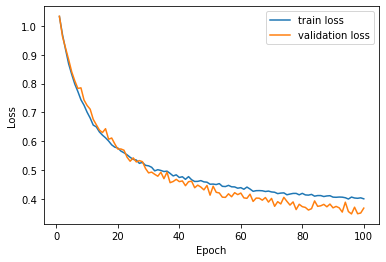


Accuracy: 0.8722222222222222
Precision: 0.8729125505875314
Recall: 0.8722222222222222
F1-Score: 0.8722449993544039
Training time:  1.3333333333333333  minutes.


In [33]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) 
            for x,y in zip(X_te,Y_te)]

plot_train_val_loss(loss_tr,dev_loss)

print()
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))
print("Training time: ",cost_time/60," minutes.")

### Discuss how did you choose model hyperparameters ? 

In [34]:
def grid_search(learning_rate,dropout_rate):
    print("The learning_rate:",learning_rate,"; The dropout_rate:",dropout_rate)
    
    W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[], num_classes=3)
    W[0] = w_glove
    
    W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                                W,
                                X_dev=X_dev, 
                                Y_dev=Y_dev,
                                lr=learning_rate, 
                                dropout = dropout_rate,
                                freeze_emb = True,
                                tolerance = 0.0001,
                                epochs = EPOCH)
    
    plot_train_val_loss(loss_tr,dev_loss)
    
    preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) 
                for x,y in zip(X_te,Y_te)]
    print()
    print('Accuracy:', accuracy_score(Y_te,preds_te))
    print('Precision:', precision_score(Y_te,preds_te,average='macro'))
    print('Recall:', recall_score(Y_te,preds_te,average='macro'))
    print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))
    print("-----------------------")

The learning_rate: 0.001 ; The dropout_rate: 0.2
Epoch: 0 training_loss: 1.0386985851367991 validation_loss:  1.0574650838934752
Epoch: 10 training_loss: 0.6815628141383272 validation_loss:  0.7002090866386742
Epoch: 20 training_loss: 0.5604801746233181 validation_loss:  0.5680972599498927
Epoch: 30 training_loss: 0.5093708279345427 validation_loss:  0.49992578810296656
Epoch: 40 training_loss: 0.4721931948826244 validation_loss:  0.46983946085981754
Epoch: 50 training_loss: 0.4534425278565909 validation_loss:  0.43486340597224765
Epoch: 60 training_loss: 0.4370821714778573 validation_loss:  0.4035991004984984
Epoch: 70 training_loss: 0.42194043508592266 validation_loss:  0.38775695945862126
Epoch: 80 training_loss: 0.4120163413628221 validation_loss:  0.38566904534159496
Epoch: 90 training_loss: 0.40328305227003836 validation_loss:  0.375434047707622


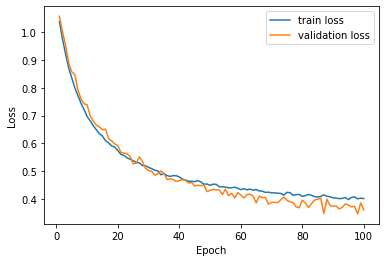


Accuracy: 0.8677777777777778
Precision: 0.8681422425904599
Recall: 0.8677777777777779
F1-Score: 0.8677016363553051
-----------------------
The learning_rate: 0.001 ; The dropout_rate: 0.5
Epoch: 0 training_loss: 1.0756979359651466 validation_loss:  1.072707949141414
Epoch: 10 training_loss: 0.8759010352807485 validation_loss:  0.8755352661529037
Epoch: 20 training_loss: 0.760410141953807 validation_loss:  0.7959005563321375
Epoch: 30 training_loss: 0.6833653902326818 validation_loss:  0.7099827994060138
Epoch: 40 training_loss: 0.6403419992674543 validation_loss:  0.6449310186759208
Epoch: 50 training_loss: 0.5998230394610473 validation_loss:  0.6397899631661649
Epoch: 60 training_loss: 0.5791473535739667 validation_loss:  0.5619952617692646
Epoch: 70 training_loss: 0.5545555966955357 validation_loss:  0.580239632593633
Epoch: 80 training_loss: 0.538998406900404 validation_loss:  0.5511228838448347
Epoch: 90 training_loss: 0.5277976506696092 validation_loss:  0.5294553319424472


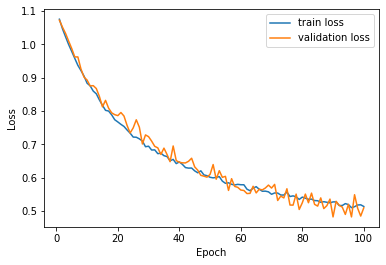


Accuracy: 0.87
Precision: 0.8698966117722611
Recall: 0.87
F1-Score: 0.8698549274381596
-----------------------
The learning_rate: 0.005 ; The dropout_rate: 0.2
Epoch: 0 training_loss: 0.8465286998823652 validation_loss:  0.8640581271692588
Epoch: 10 training_loss: 0.4385660886950045 validation_loss:  0.4099223263326728
Epoch: 20 training_loss: 0.40059356388698836 validation_loss:  0.3602372633462861
Epoch: 30 training_loss: 0.3788359732326802 validation_loss:  0.3069241701031441
Epoch: 40 training_loss: 0.36047653739863733 validation_loss:  0.3161666026733265
Epoch: 50 training_loss: 0.35401048614485864 validation_loss:  0.3263886678133255
Epoch: 60 training_loss: 0.34527376485904215 validation_loss:  0.3183974608296058
Epoch: 70 training_loss: 0.34166505563282845 validation_loss:  0.30994852822741126
Epoch: 80 training_loss: 0.3390032267678472 validation_loss:  0.2764229187371436
Epoch: 90 training_loss: 0.3353816750139172 validation_loss:  0.2881878191500058


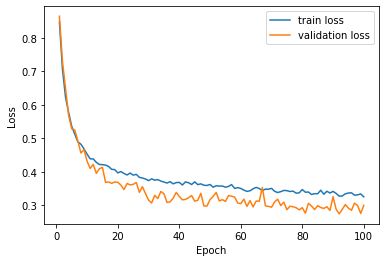


Accuracy: 0.8722222222222222
Precision: 0.8732088321409416
Recall: 0.8722222222222222
F1-Score: 0.8725404099314336
-----------------------
The learning_rate: 0.005 ; The dropout_rate: 0.5
Epoch: 0 training_loss: 0.9722448810462841 validation_loss:  0.977227185149283
Epoch: 10 training_loss: 0.5922645802698119 validation_loss:  0.6078315015751329
Epoch: 20 training_loss: 0.5148295058001187 validation_loss:  0.4647632876836487
Epoch: 30 training_loss: 0.48299225182565064 validation_loss:  0.43987484288007894
Epoch: 40 training_loss: 0.4662241365251406 validation_loss:  0.4177420093647037
Epoch: 50 training_loss: 0.4406391937913128 validation_loss:  0.44134954228017353
Epoch: 60 training_loss: 0.44199853210640877 validation_loss:  0.4178065963202799
Epoch: 70 training_loss: 0.43690607082271393 validation_loss:  0.3613009506409296
Epoch: 80 training_loss: 0.40359568980315513 validation_loss:  0.3865992358606551
Epoch: 90 training_loss: 0.41195530498754673 validation_loss:  0.4040079517689

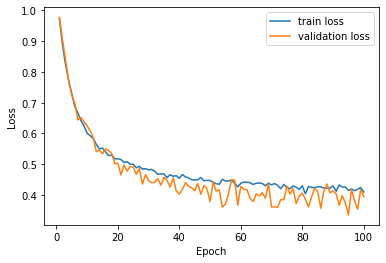


Accuracy: 0.87
Precision: 0.8713961742355197
Recall: 0.8700000000000001
F1-Score: 0.8703605513341729
-----------------------


In [35]:
learning_rate = [0.001, 0.005]
dropout_rate = [0.2,0.5]

for lr in learning_rate:
    for drop_r in dropout_rate:
        grid_search(lr,drop_r)

### Discussion
**Here grid search is used for hyperparameter selection. Two learning rates and two drop out rates were tested. After grid search, the best combination of hyperparameters was found to be: learning rate of 0.001 and dropout rate of 0.2. The best accuracy was 87%. Models that use pre-training perform better than those that do not. The models are correct because they converges overall on the train and validation sets, but there are local fluctuations, probably due to the fact that lr is not small enough.**

# Extend to support deeper architectures 

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. Do deeper architectures increase performance?

In [36]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    
    # softmax derivate
    y_preds = out_vals['y'][0]
    y_preds[y] = y_preds[y]-1
    g = y_preds.reshape((1,out_vals['y'].shape[1]))
    
    for i in range(len(W)-1,0,-1): # from w-1 to 1 (not 0)
        W[i] = W[i] - lr * np.dot(out_vals['a'][i-1].T,g)
        g = np.dot(g,W[i].T)
        g = g * relu_derivative(out_vals['h'][i-1])
    
    if freeze_emb == False:
        #X_vec = XtoVector(x, W)
        X_vec = np.zeros((1,len(W[0])))[0]
        for i in x:
            X_vec[i] = 1
        
        X_vec = X_vec.reshape((1,X_vec.shape[0]))
        g = g * relu_derivative(out_vals['h'][0])
        W[0] = W[0] - lr * np.dot(X_vec.T,g)
    
    return W

In [37]:
# example one hidden layer; hidden_dim=[400]
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[400], num_classes=3)
W[0] = w_glove

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

Shape W0 (1103, 300)
Shape W1 (300, 400)
Shape W2 (400, 3)


Epoch: 0 training_loss: 1.0327577915963164 validation_loss:  1.038408690658659
Epoch: 10 training_loss: 0.4846619021389724 validation_loss:  0.481059949144122
Epoch: 20 training_loss: 0.4064506208323306 validation_loss:  0.35643841514884295
Epoch: 30 training_loss: 0.3696736546710469 validation_loss:  0.31911380103712583
Epoch: 40 training_loss: 0.36470113043955654 validation_loss:  0.29449395790493665
Epoch: 50 training_loss: 0.3675084766457477 validation_loss:  0.3312472039039485
Epoch: 60 training_loss: 0.34353003708836133 validation_loss:  0.3334757498860381
Epoch: 70 training_loss: 0.3257987844793935 validation_loss:  0.29012774162002025
Epoch: 80 training_loss: 0.331786626542957 validation_loss:  0.30039762493223954
Epoch: 90 training_loss: 0.32911614198735273 validation_loss:  0.26139107021361385


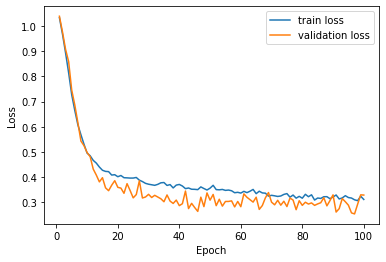


Accuracy: 0.8622222222222222
Precision: 0.865024520221756
Recall: 0.8622222222222223
F1-Score: 0.8627744909291682
Training time:  3.033333333333333  minutes.


In [38]:
# freeze_emb = True 
start_time_temp = datetime.now()

W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.001, 
                            dropout=0.2,
                            freeze_emb=True,
                            tolerance=0.0001,
                            epochs=EPOCH)

# plot the loss
plot_train_val_loss(loss_tr,dev_loss)

preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) 
            for x,y in zip(X_te,Y_te)]

print()
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

end_time = datetime.now()
cost_time=(end_time-start_time_temp).seconds
print("Training time: ",cost_time/60," minutes.")

### Discuss how did you choose model hyperparameters ? 

In [39]:
def grid_search(dropout_rate,hidden_dim):
    print("The dropout_rate:",dropout_rate,"; hidden_dim:",hidden_dim)
   
    W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[hidden_dim], num_classes=3)
    W[0] = w_glove
    
    for i in range(len(W)):
        print('Shape W'+str(i), W[i].shape)
    
    W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                                W,
                                X_dev=X_dev, 
                                Y_dev=Y_dev,
                                lr=0.001, 
                                dropout = dropout_rate,
                                freeze_emb = True,
                                tolerance = 0.0001,
                                epochs = EPOCH)
    
   # plot the loss 
    plot_train_val_loss(loss_tr,dev_loss)
    
    preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) 
                for x,y in zip(X_te,Y_te)]
    print()
    print('Accuracy:', accuracy_score(Y_te,preds_te))
    print('Precision:', precision_score(Y_te,preds_te,average='macro'))
    print('Recall:', recall_score(Y_te,preds_te,average='macro'))
    print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))
    print("-----------------------")

The dropout_rate: 0.2 ; hidden_dim: 300
Shape W0 (1103, 300)
Shape W1 (300, 300)
Shape W2 (300, 3)
Epoch: 0 training_loss: 1.0448148584105552 validation_loss:  1.052954819145735
Epoch: 10 training_loss: 0.49570314127299187 validation_loss:  0.47679149198840404
Epoch: 20 training_loss: 0.40428682516113934 validation_loss:  0.37751448939958154
Epoch: 30 training_loss: 0.37073537050294886 validation_loss:  0.31290583832101826
Epoch: 40 training_loss: 0.35647746663451135 validation_loss:  0.31294958916241994
Epoch: 50 training_loss: 0.35428971768162965 validation_loss:  0.29511789898139956
Epoch: 60 training_loss: 0.3449396164893831 validation_loss:  0.29234799237495057
Epoch: 70 training_loss: 0.34164203571043195 validation_loss:  0.2848297617597375
Epoch: 80 training_loss: 0.32892998342940855 validation_loss:  0.2865455875844779
Epoch: 90 training_loss: 0.32511059869514086 validation_loss:  0.2686150299418168


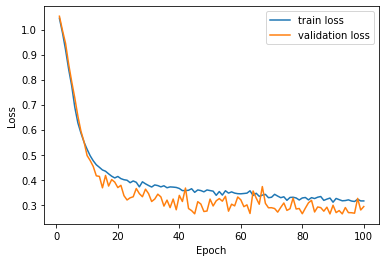


Accuracy: 0.8666666666666667
Precision: 0.8674326359046732
Recall: 0.8666666666666667
F1-Score: 0.866677255379554
-----------------------
The dropout_rate: 0.2 ; hidden_dim: 400
Shape W0 (1103, 300)
Shape W1 (300, 400)
Shape W2 (400, 3)
Epoch: 0 training_loss: 1.0378982199392481 validation_loss:  1.0452800799927657
Epoch: 10 training_loss: 0.47855239162784396 validation_loss:  0.47767752679571507
Epoch: 20 training_loss: 0.3983536702154859 validation_loss:  0.3724674187466679
Epoch: 30 training_loss: 0.37121501803754225 validation_loss:  0.2807277379391273
Epoch: 40 training_loss: 0.3573314959862573 validation_loss:  0.3330695765472307
Epoch: 50 training_loss: 0.34809503575766915 validation_loss:  0.29844907505963786
Epoch: 60 training_loss: 0.34368728708790197 validation_loss:  0.31250910930681874
Epoch: 70 training_loss: 0.32573791550588493 validation_loss:  0.27782827840711927
Epoch: 80 training_loss: 0.3178614310694963 validation_loss:  0.32161415469189586
Epoch: 90 training_loss:

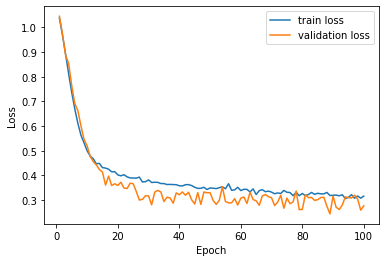


Accuracy: 0.8622222222222222
Precision: 0.8641550647917103
Recall: 0.8622222222222221
F1-Score: 0.8623361810406731
-----------------------
The dropout_rate: 0.5 ; hidden_dim: 300
Shape W0 (1103, 300)
Shape W1 (300, 300)
Shape W2 (300, 3)
Epoch: 0 training_loss: 1.0918854552322206 validation_loss:  1.094590949584794
Epoch: 10 training_loss: 0.9289524746941854 validation_loss:  0.9463946331457433
Epoch: 20 training_loss: 0.6566146137897075 validation_loss:  0.6511748611925452
Epoch: 30 training_loss: 0.538581867096549 validation_loss:  0.47498375324685893
Epoch: 40 training_loss: 0.502037490798984 validation_loss:  0.4296015976674998
Epoch: 50 training_loss: 0.47600765105640125 validation_loss:  0.4752394556852565
Epoch: 60 training_loss: 0.46105373965439006 validation_loss:  0.4375491213684748
Epoch: 70 training_loss: 0.45059069081777164 validation_loss:  0.4470405181263383
Epoch: 80 training_loss: 0.43329104886034303 validation_loss:  0.3763232098458812
Epoch: 90 training_loss: 0.4302

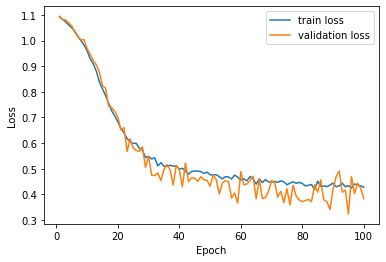


Accuracy: 0.87
Precision: 0.8709977277422021
Recall: 0.87
F1-Score: 0.8700929358590218
-----------------------
The dropout_rate: 0.5 ; hidden_dim: 400
Shape W0 (1103, 300)
Shape W1 (300, 400)
Shape W2 (400, 3)
Epoch: 0 training_loss: 1.0851561368693052 validation_loss:  1.084659352406839
Epoch: 10 training_loss: 0.8786458704722208 validation_loss:  0.89324011810071
Epoch: 20 training_loss: 0.6113595124877594 validation_loss:  0.6250085990213415
Epoch: 30 training_loss: 0.5056889765547821 validation_loss:  0.46280256257764063
Epoch: 40 training_loss: 0.49915598441249787 validation_loss:  0.42679114323990175
Epoch: 50 training_loss: 0.45565432068633366 validation_loss:  0.4644851527289101
Epoch: 60 training_loss: 0.4585139911186254 validation_loss:  0.38636315052941145
Epoch: 70 training_loss: 0.4422417339832058 validation_loss:  0.3289666655391391
Epoch: 80 training_loss: 0.45158231547635697 validation_loss:  0.4671581951615125
Epoch: 90 training_loss: 0.4464487640422555 validation_los

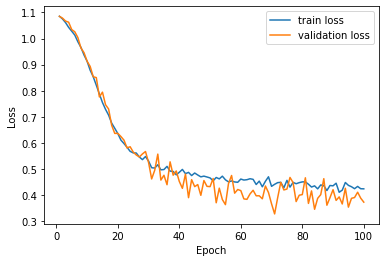


Accuracy: 0.8677777777777778
Precision: 0.8684811920106038
Recall: 0.8677777777777779
F1-Score: 0.8678858679832416
-----------------------


In [40]:
dropout_rate = [0.2,0.5]
hidden_dim = [300,400]

for drop_r in dropout_rate:
    for hid_d in hidden_dim:
        grid_search(drop_r,hid_d)

### Discussion

**Here grid search is used for hyperparameter selection. Two hidden layer dimensions and two drop out rates were tested. After grid search, the best combination of hyperparameters was found to be: hidden layer dimensions of 0.5 and dropout rate of 0.5. The best accuracy was 86.7%. The model is correct because it converges overall on the train and validation sets, but there are local fluctuations, probably due to the fact that learning rate is not small enough. The higher the dropout for the same dimension of hidden layers, the higher the accuracy, probably because the dropout suppresses the overfitting of deeper networks to a certain extent.**

In [41]:
end_time = datetime.now()
cost_time=(end_time-start_time).seconds
print("Over all raining time(include grid search): ",cost_time/60," minutes.")

Over all raining time(include grid search):  42.233333333333334  minutes.


## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  |0.8497   | 0.8477  | 0.8475  | 0.8477  |
| Average Embedding (Pre-trained)  |  0.8723 | 0.8722  |  0.8725 | 0.8722  |
| Average Embedding (Pre-trained) + X hidden layers    |  0.8709 | 0.87  | 0.87  |  0.87 |


Please discuss why your best performing model is better than the rest.

**As can be seen from the performance, the two models using the pre-trained embedding layer have similar results, both outperforming the average embedding. The main reason for this is that pre-trained embedding is likely to facilitate the extraction and learning of features. The reason why the third model is slightly worse than the second is probably because the addition of hidden layers makes the model more prone to overfitting.**